<center><h1>Liu_Zihan_HW4</h1></center>
<br>
<br>

Name: Zihan Liu
<br>
Github Username: zihan0324
<br>
USC ID: 1534981630

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import statsmodels.api as sm

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler, label_binarize
from imblearn.over_sampling import SMOTE

Get the AReM Data Set

In [2]:
def read_AReM_data_files(dir_str: str, start_row: int, col_number: int) -> pd.DataFrame:
    """
    Read all csv files in the provided directory.
    Args:
        dir_str: a certain direcotry containing data files
        start_row: row number start to read (previous rows will be skipped)
        col_number: number of columns that will be used
    Return: df_data_dict
    """
    df_data_dict = {}
    
    for f in os.listdir(dir_str):
        file_name = dir_str.split('/')[-1] + '_' + f
        file_data = pd.read_csv(os.path.join(dir_str, f),
                                skiprows=range(0, start_row), 
                                usecols=range(0, col_number))
        
        # Tackle None value
        if file_data.isna().any().any():
            file_data_values = pd.read_csv(os.path.join(dir_str, f),
                                          sep=' ',
                                          skiprows=range(0, start_row + 1), 
                                          usecols=range(0, col_number),
                                          header=None).values
            file_data_columns = file_data.columns
            
            file_data = pd.DataFrame(file_data_values, columns=file_data_columns)

            
        df_data_dict[file_name] = file_data
        
    return df_data_dict

In [3]:
DATA_PATH = '../data/AReM/'
V_START_ROW = 4 # read from 5th row (row number is 4)
V_COL_NUMBER = 7

# Read data files in each folder
folder_list = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]

data_dict = {}

for folder in folder_list:
    data_dict.update(read_AReM_data_files(os.path.join(DATA_PATH, folder), V_START_ROW, V_COL_NUMBER))

### (b) Splitting Data

Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [4]:
test_data_key = ['bending1_dataset1.csv', 'bending1_dataset2.csv',
                'bending2_dataset1.csv', 'bending2_dataset2.csv',
                'cycling_dataset1.csv', 'cycling_dataset2.csv', 'cycling_dataset3.csv',
                'lying_dataset1.csv', 'lying_dataset2.csv', 'lying_dataset3.csv', 
                'sitting_dataset1.csv', 'sitting_dataset2.csv', 'sitting_dataset3.csv', 
                'standing_dataset1.csv', 'standing_dataset2.csv', 'standing_dataset3.csv', 
                'walking_dataset1.csv', 'walking_dataset2.csv', 'walking_dataset3.csv', ]

test_data = {k: v for k, v in data_dict.items() if k in test_data_key}
train_data = {k: v for k, v in data_dict.items() if k not in test_data_key}

In [5]:
test_data

{'bending1_dataset1.csv':      # Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
 0                  0      39.25       0.43      22.75       0.43      33.75   
 1                250      39.25       0.43      23.00       0.00      33.00   
 2                500      39.25       0.43      23.25       0.43      33.00   
 3                750      39.50       0.50      23.00       0.71      33.00   
 4               1000      39.50       0.50      24.00       0.00      33.00   
 ..               ...        ...        ...        ...        ...        ...   
 475           118750      43.33       0.47      25.00       0.00      30.00   
 476           119000      43.50       0.50      25.50       0.50      30.00   
 477           119250      43.50       0.50      24.75       0.43      30.00   
 478           119500      43.50       0.50      24.33       0.47      30.00   
 479           119750      43.50       0.50      24.25       0.43      30.00   
 
      var_rss

### (c) Feature Extraction

minimum, maximum, mean, median, standard deviation, first quartile, and third quartile

In [6]:
C_MINIMUM = 'min'
C_MAXIMUM = 'max'
C_MEAN = 'mean'
C_MEDIAN = 'median'
C_STANDARD_DEVIATION = 'std'
C_FIRST_QUARTILE = 'first_quartile'
C_THIRD_QUARTILE = 'thrid_quartile'

def cal_stats(time_series_data: pd.Series) -> dict:
    """
    Calculate 7 statitical features from time series data
    Args:
        time_series_data: the origin time series data
    Return: stat: dict of stastical features
    """
    data_description = time_series_data.describe()
    stat = {}
    stat[C_MINIMUM] = data_description['min']
    stat[C_MAXIMUM] = data_description['max']
    stat[C_MEAN] = data_description['mean']
    stat[C_MEDIAN] = data_description['50%']
    stat[C_STANDARD_DEVIATION] = data_description['std']
    stat[C_FIRST_QUARTILE] = data_description['25%']
    stat[C_THIRD_QUARTILE] = data_description['75%']
    
    return stat

In [7]:
# Calculate statistical features of 88 instances
V_COLUMN_NAMES = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
V_STAT_FEATURE_NAMES = []
C_ACTIVITY = 'activity'
V_TIME_DOMAIN_DATA = []

for key, value in data_dict.items():
    instance = key.split('.')[0]
    
    if len(V_STAT_FEATURE_NAMES) == 0:
        for col in V_COLUMN_NAMES:
            V_STAT_FEATURE_NAMES.append(C_MINIMUM + '_' + col)
            V_STAT_FEATURE_NAMES.append(C_MAXIMUM + '_' + col)
            V_STAT_FEATURE_NAMES.append(C_MEAN + '_' + col)
            V_STAT_FEATURE_NAMES.append(C_MEDIAN + '_' + col)
            V_STAT_FEATURE_NAMES.append(C_STANDARD_DEVIATION + '_' + col)
            V_STAT_FEATURE_NAMES.append(C_FIRST_QUARTILE + '_' + col)
            V_STAT_FEATURE_NAMES.append(C_THIRD_QUARTILE + '_' + col)
            
    feature_data = []
    for col in V_COLUMN_NAMES:
        stats = cal_stats(value[col])
        feature_data += list(stats.values())
    
    feature_data.append(instance)
    V_TIME_DOMAIN_DATA.append(feature_data)
    
V_TIME_DOMIAN_COLUMNS = [*V_STAT_FEATURE_NAMES, C_ACTIVITY]
df_time_domain_features = pd.DataFrame(V_TIME_DOMAIN_DATA, columns=V_TIME_DOMIAN_COLUMNS)

print(df_time_domain_features[V_STAT_FEATURE_NAMES].head())

   min_avg_rss12  max_avg_rss12  mean_avg_rss12  median_avg_rss12  \
0          36.25          48.00       43.969125             44.50   
1          37.00          48.00       43.454958             43.25   
2          33.00          47.75       42.179812             43.50   
3          33.00          45.75       41.678063             41.75   
4          37.25          45.00       40.624792             40.50   

   std_avg_rss12  first_quartile_avg_rss12  thrid_quartile_avg_rss12  \
0       1.618364                     43.31                     44.67   
1       1.386098                     42.50                     45.00   
2       3.670666                     39.15                     45.00   
3       2.243490                     41.33                     42.75   
4       1.476967                     39.25                     42.00   

   min_var_rss12  max_var_rss12  mean_var_rss12  ...  std_avg_rss23  \
0            0.0           1.50        0.413125  ...       3.318301   
1         

In [8]:
df_time_domain_features

min_avg_rss12  max_avg_rss12  mean_avg_rss12  median_avg_rss12  \
0           36.25          48.00       43.969125             44.50   
1           37.00          48.00       43.454958             43.25   
2           33.00          47.75       42.179812             43.50   
3           33.00          45.75       41.678063             41.75   
4           37.25          45.00       40.624792             40.50   
..            ...            ...             ...               ...   
83          18.50          44.25       35.752354             36.00   
84          24.25          45.00       37.177042             36.25   
85          23.33          43.50       36.244083             36.75   
86          26.25          44.25       36.957458             36.29   
87          27.75          44.67       37.144833             36.33   

    std_avg_rss12  first_quartile_avg_rss12  thrid_quartile_avg_rss12  \
0        1.618364                   43.3100                     44.67   
1        1.386098                   42.5000                     45.00   
2        3.670666                   39.1500                     45.00   
3        2.243490                   41.3300                     42.75   
4        1.476967                   39.2500                     42.00   
..            ...                       ...                       ...   
83       4.614802                   33.0000                     39.33   
84       3.581301                   34.5000                     40.25   
85       3.822016                   33.4575                     39.25   
86       3.434863                   34.5000                     40.25   
87       3.758904                   34.0000                     40.50   

    min_var_rss12  max_var_rss12  mean_var_rss12  ...  \
0             0.0           1.50        0.413125  ...   
1             0.0           1.58        0.378083  ...   
2             0.0           3.00        0.696042  ...   
3             0.0           2.83        0.535979  ...   
4             0.0           1.30        0.358604  ...   
..            ...            ...             ...  ...   
83            0.0          12.60        3.328104  ...   
84            0.0           8.58        2.374208  ...   
85            0.0           9.71        2.736021  ...   
86            0.0           8.64        2.420083  ...   
87            0.0          10.76        2.419062  ...   

    first_quartile_avg_rss23  thrid_quartile_avg_rss23  min_var_rss23  \
0                    20.5000                   23.7500            0.0   
1                    22.2500                   24.0000            0.0   
2                    30.4575                   36.3300            0.0   
3                    28.4575                   31.2500            0.0   
4                    33.0000                   36.0000            0.0   
..                       ...                       ...            ...   
83                   14.0000                   18.0625            0.0   
84                   17.9500                   21.7500            0.0   
85                   15.7500                   21.0000            0.0   
86                   14.0000                   18.2500            0.0   
87                   15.0000                   18.7500            0.0   

    max_var_rss23  mean_var_rss23  median_var_rss23  std_var_rss23  \
0            2.96        0.555312             0.490       0.487826   
1            5.26        0.679646             0.500       0.622534   
2            2.18        0.613521             0.500       0.524317   
3            1.79        0.383292             0.430       0.389164   
4            1.92        0.570583             0.430       0.582915   
..            ...             ...               ...            ...   
83           9.39        3.069667             2.770       1.748326   
84           9.34        2.921729             2.500       1.852600   
85          11.15        3.530500             3.110       1.963685   
86           8.34       

Considering the rank of aggregation of standard deviation and confidence interval range. 

The most important 3 features I chose are:


1. Min
2. Mean
3. Max

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [9]:
# Add a label to identify bending and other activities
C_BENDING_LABEL = 'is_bending'

df_time_domain_features[C_BENDING_LABEL] = df_time_domain_features[C_ACTIVITY].\
                                                    apply(lambda x: 1 if 'bending' in x else 0)

In [10]:
# Only choose min, mean, and max from time series 1, 2, and 6
V_DESIRED_SERIES = V_COLUMN_NAMES[0:2] + [V_COLUMN_NAMES[5]]
V_DESIRED_FEATURES = [C_MINIMUM, C_MEAN, C_MAXIMUM]


def select_data(time_domain_features: pd.DataFrame,\
                       desired_series: list,\
                       desired_features: list) -> pd.DataFrame:
    """
    Select time domain features from certain time series
    Args:
        time_domain_features: origin data of all time domain features from all time series
        desired_series: list of desired time series
        desired_features: list of desired features
    """
    desired_column_names = []
    for f in desired_features:
        for s in desired_series:
            desired_column_names.append(f + '_' + s)
    
    desired_column_names.append(C_BENDING_LABEL)
    
    return time_domain_features[desired_column_names]

In [12]:
# Split time domain features of training data
df_train_features = df_time_domain_features[~(df_time_domain_features[C_ACTIVITY].\
                                              apply(lambda x: True if x + '.csv' in test_data_key else False))]
df_test_features = df_time_domain_features[df_time_domain_features[C_ACTIVITY].\
                                              apply(lambda x: True if x + '.csv' in test_data_key else False)]


df_train_selected_features = select_data(df_train_features, V_DESIRED_SERIES, V_DESIRED_FEATURES)

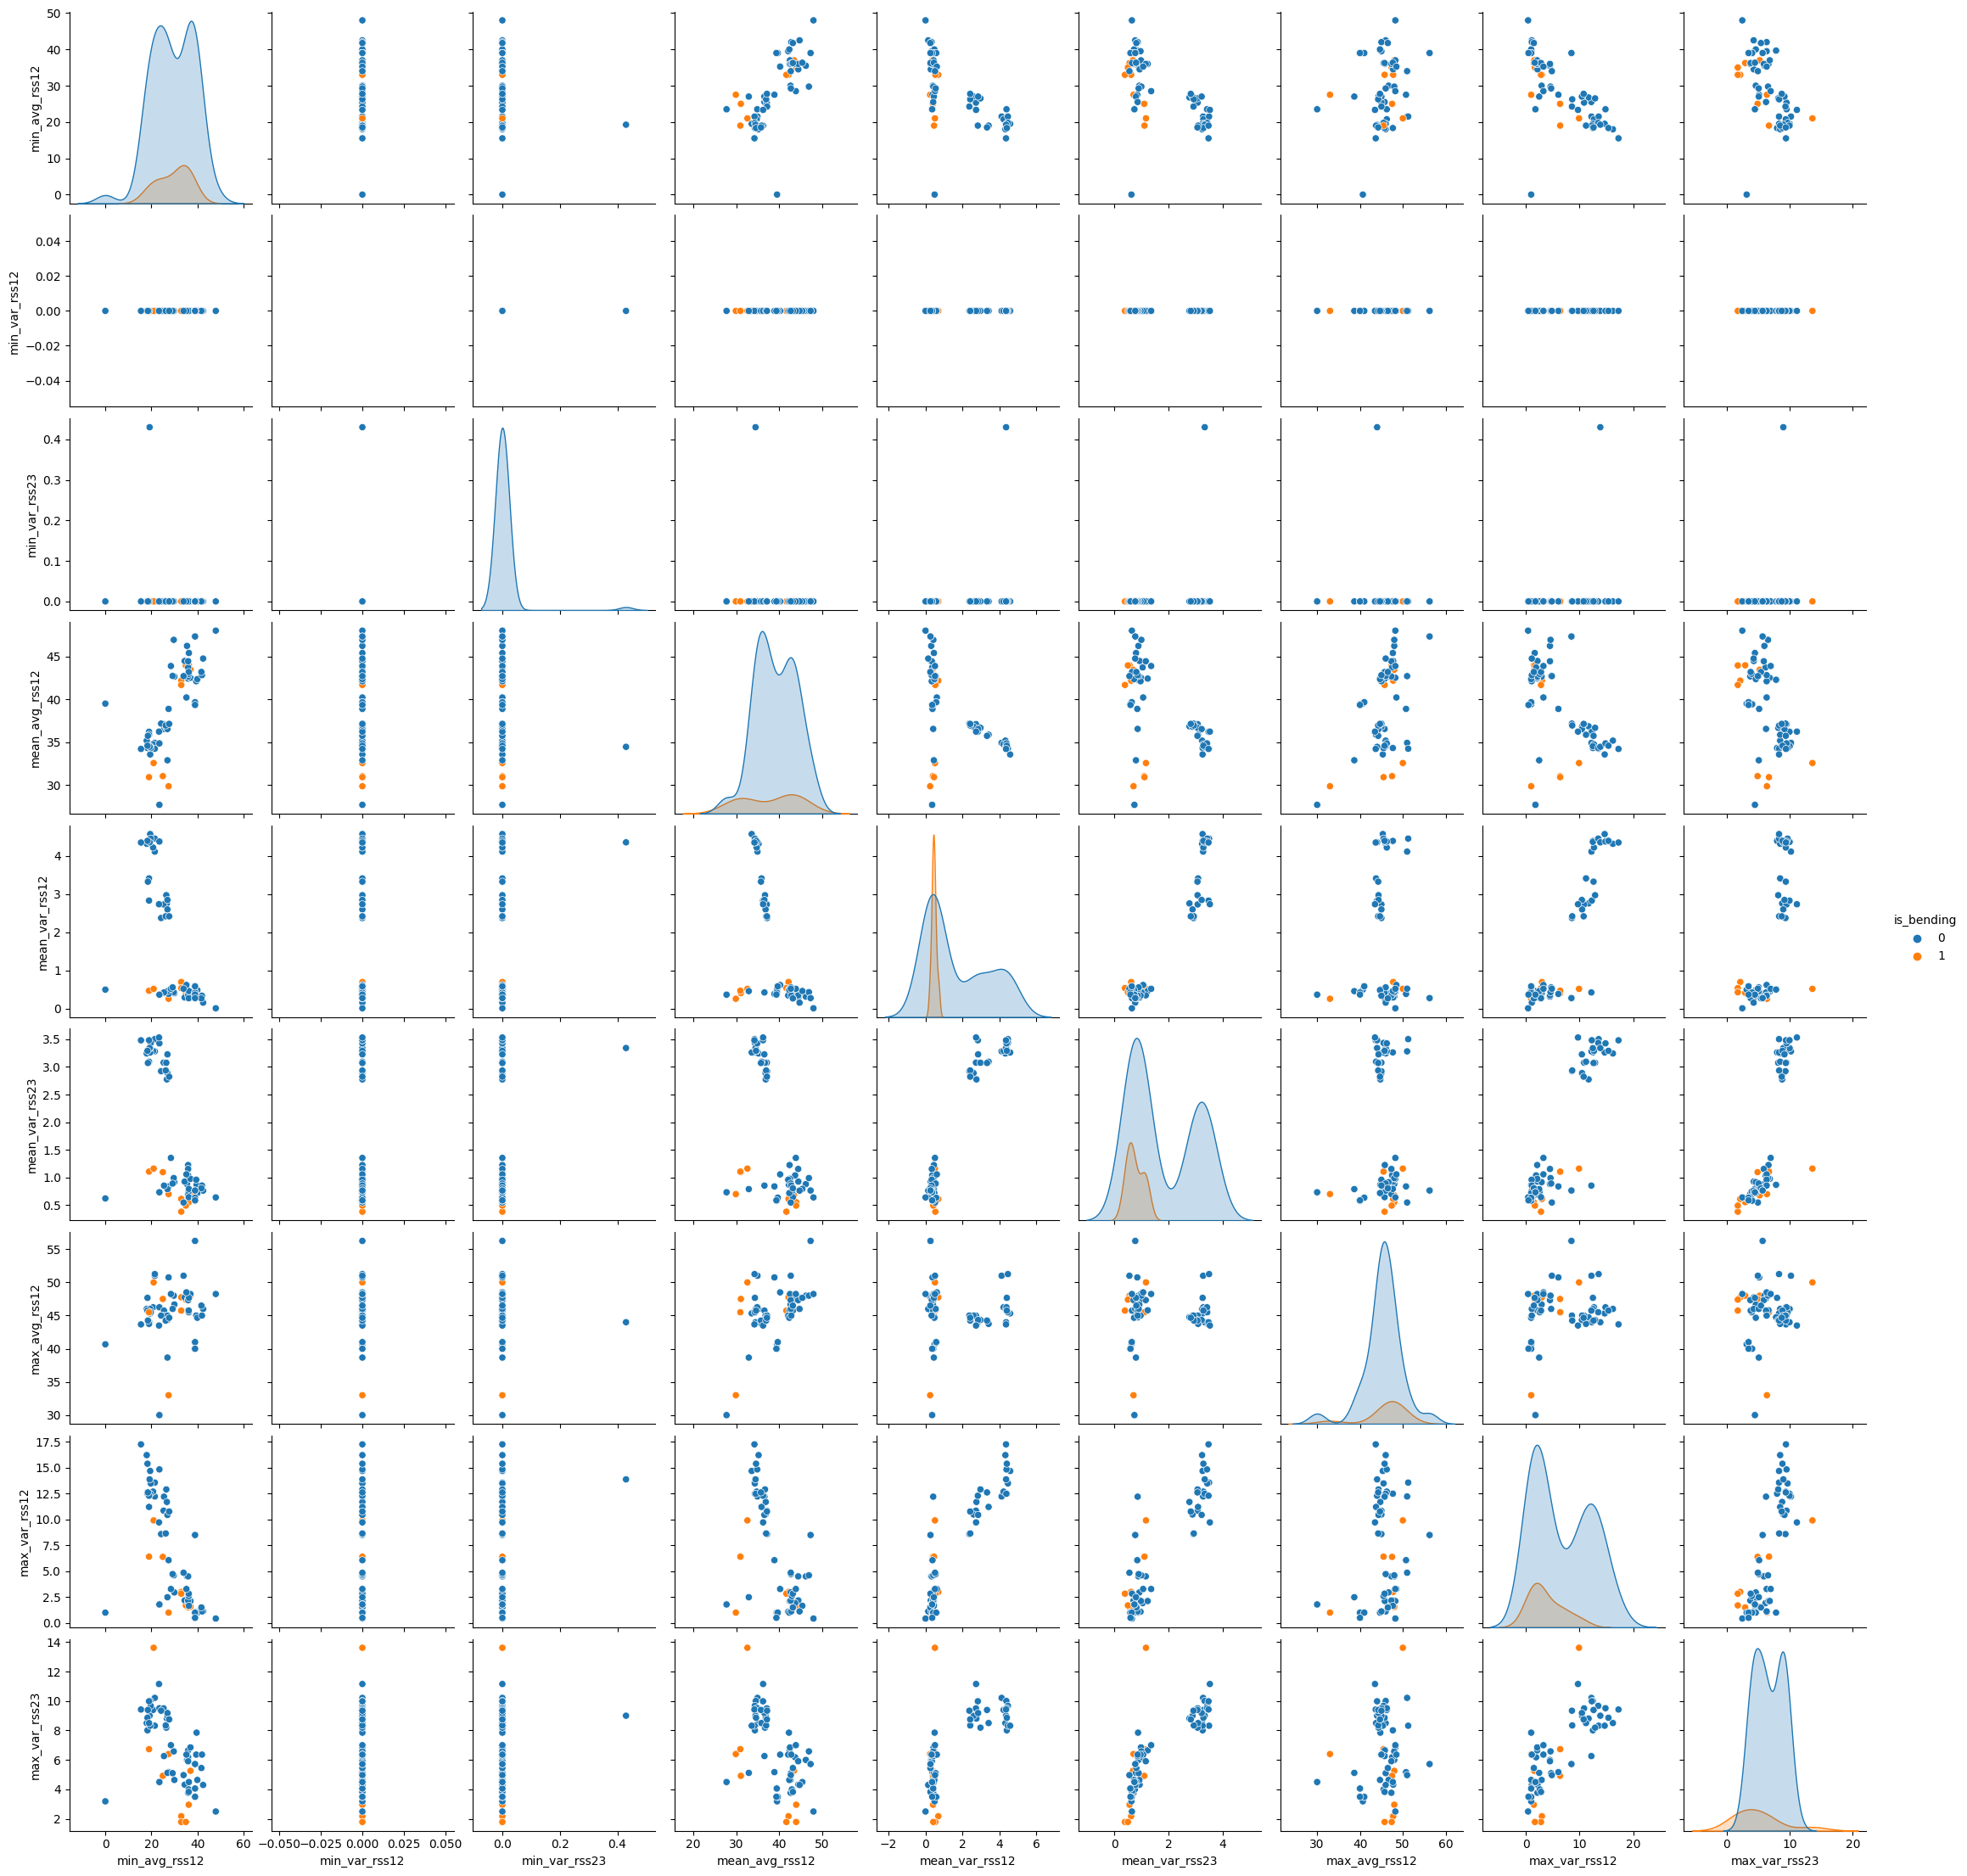

In [13]:
warnings.filterwarnings('ignore')
sns.pairplot(df_train_selected_features, hue=C_BENDING_LABEL)

#### ii. Splitted Plots

In [14]:
def split_time_series(time_series_data: pd.DataFrame, l: int) -> pd.DataFrame:
    """
    Split each time series into several equal length time series
    Args:
        time_series_data: origin time series data like:
            # Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
 0                 0          42.00       0.71      21.25       0.43      30.00       0.00
 1               250          41.50       0.50      20.25       1.48      31.25       1.09
 2               500          41.50       0.50      14.25       1.92      33.00       0.00
        l: number of splitted time series for each time series
    Return: df_splitted_features
    """
    splitted_time_series = np.array_split(time_series_data, l)
    
    df_splitted_features = pd.DataFrame()
    
    for i in range(l):
        ts = splitted_time_series[i]
        feature_names = []
        feature_data = []
        for col in V_COLUMN_NAMES:
            feature_data.append(ts[col].min())
            feature_data.append(ts[col].mean())
            feature_data.append(ts[col].max())
            
            feature_names.append(C_MINIMUM + '_' + col + '_' +str(i + 1))
            feature_names.append(C_MEAN + '_' + col + '_' +str(i + 1))
            feature_names.append(C_MAXIMUM + '_' + col + '_' +str(i + 1))
        
        df_ts_features = pd.DataFrame([feature_data], columns=feature_names)
        
        df_splitted_features = pd.concat([df_splitted_features, df_ts_features], axis=1)

    return df_splitted_features

In [15]:
# Split training set into two (approximately) equal length time series
L = 2

df_train_splitted_features = pd.DataFrame()

for key, value in train_data.items():
    is_bending = 1 if 'bending' in key else 0
    
    df_instance_splitted_features = split_time_series(value, L)
    df_instance_splitted_features[C_BENDING_LABEL] = is_bending
    
    df_train_splitted_features = pd.concat([df_train_splitted_features, df_instance_splitted_features], axis=0)
    
df_train_splitted_features = df_train_splitted_features.reset_index(drop=True)
print(df_train_splitted_features.head())

   min_avg_rss12_1  mean_avg_rss12_1  max_avg_rss12_1  min_var_rss12_1  \
0            36.67         43.486208            45.00              0.0   
1            39.00         44.117042            48.00              0.0   
2            33.75         43.278875            47.75              0.0   
3            33.00         41.621208            45.75              0.0   
4            36.50         44.057167            46.50              0.0   

   mean_var_rss12_1  max_var_rss12_1  min_avg_rss13_1  mean_avg_rss13_1  \
0          0.378667             1.30             4.00         16.397250   
1          0.250042             1.30             6.25         17.744167   
2          0.673292             3.00            11.00         23.141250   
3          0.623083             2.83             3.00         19.081458   
4          0.381042             1.50            14.25         23.096792   

   max_avg_rss13_1  min_var_rss13_1  ...  min_var_rss13_2  mean_var_rss13_2  \
0            26.33       

In [16]:
# Extract splitted time series from origin time series 1, 2, 6
def gen_splitted_series_names(desired_series: list, l: int) -> list:
    """
    Generate the column names of splitted time series from origin desired time series
    e.g., l=2 'avg_rss12' -> ['avg_rss12_1','avg_rss12_2']
    Args:
        desired_series: column names of desired origin time series
        l: number of splitted time series
    Return：desired_splitted_series
    """
    desired_splitted_series = []
    for ts in desired_series:
        for i in range(l):
            desired_splitted_series.append(ts + '_' + str(i + 1))
            
    return desired_splitted_series
    
df_train_selected_features_2 = select_data(df_train_splitted_features,\
                                           gen_splitted_series_names(V_DESIRED_SERIES, 2),\
                                           V_DESIRED_FEATURES)

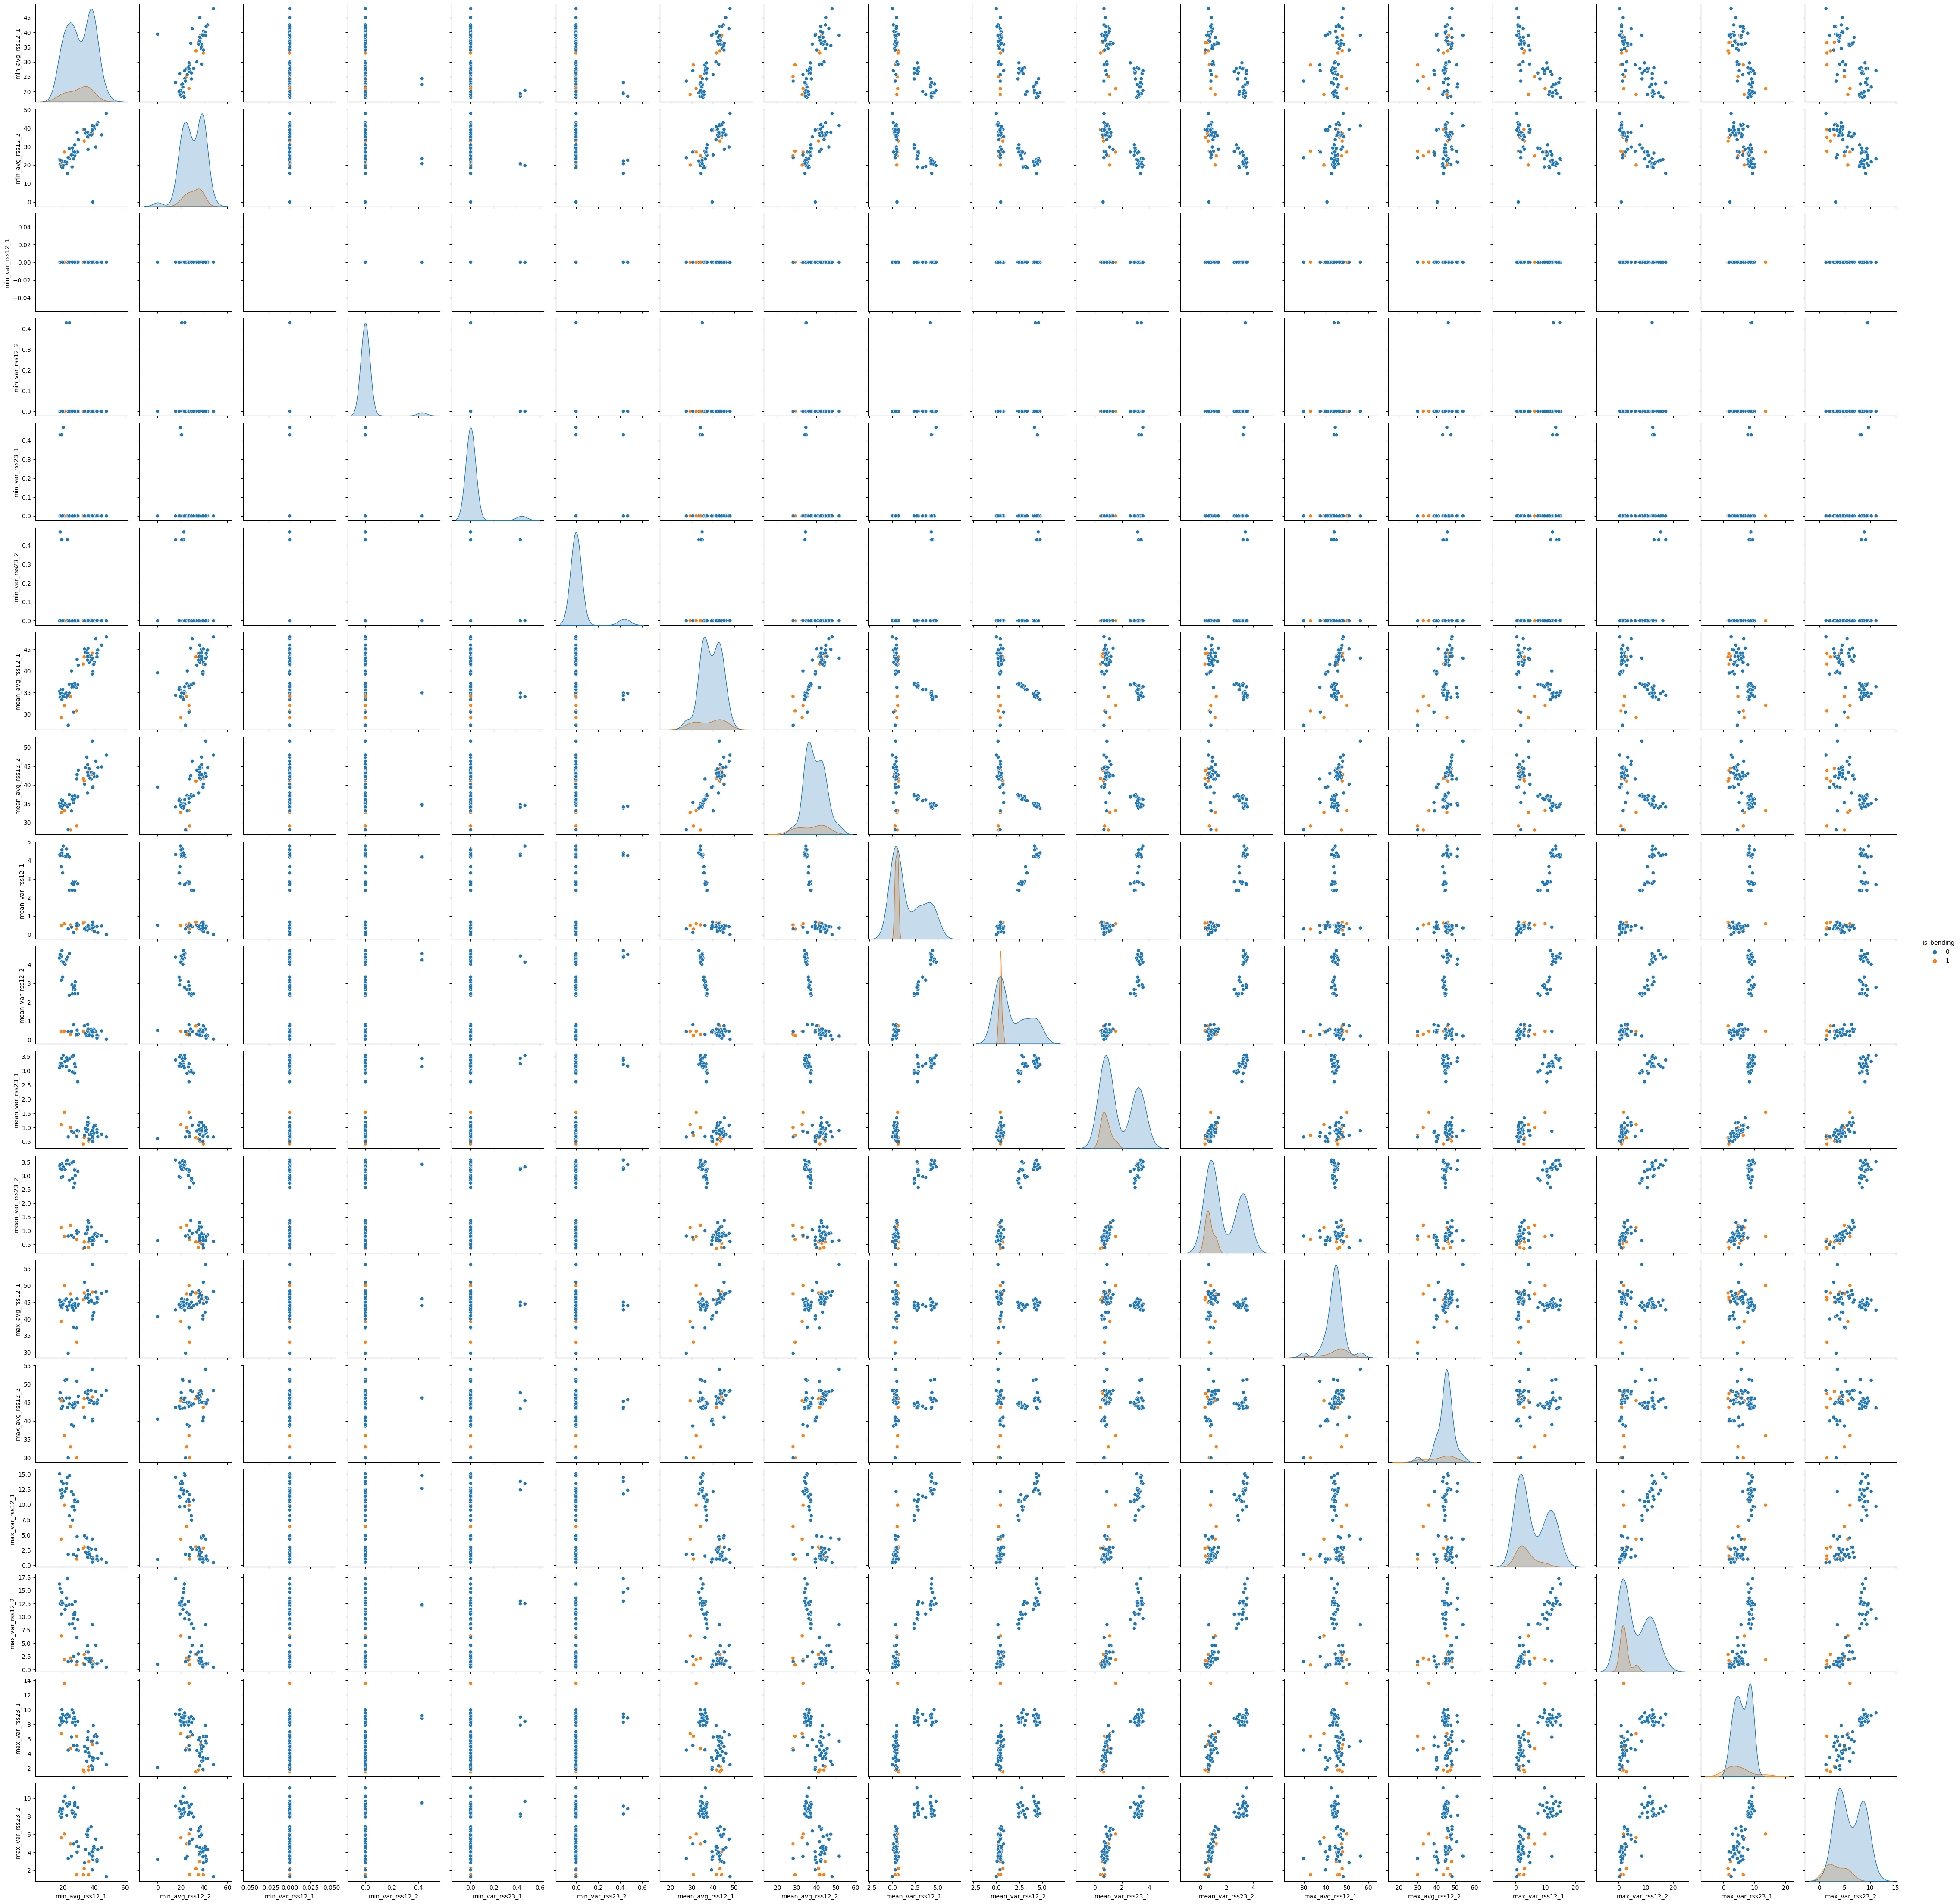

In [17]:
# Plot features from splitted time series
warnings.filterwarnings('ignore')
sns.pairplot(df_train_selected_features_2, hue=C_BENDING_LABEL)

After splitting each time series into 2 equal-length time series, the scatterplot of bending and non-bending data points are separated more clearly.

#### iii. Time Series Segments

Ref: 

1. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

2. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [18]:
def transform_time_series_binary(data: dict, l: int):
    """
    1. Add is_bending label as response variable
    2. Split origin time series into l eqaul length time series
    3. Get desired features from splitted time series
    Args:
        data: keys are instance names, values are dataframes of origin time series
        l: number of splits
    Return: df_selected_features
    """
    df_splitted_features = pd.DataFrame()
    for key, value in data.items():
        is_bending = 1 if 'bending' in key else 0
        
        df_instance_splitted_features = split_time_series(value, l)
        df_instance_splitted_features[C_BENDING_LABEL] = is_bending

        df_splitted_features = pd.concat([df_splitted_features, df_instance_splitted_features], axis=0)
    
    df_splitted_features = df_splitted_features.reset_index(drop=True)
    
    # Select min, mean, max from all split time series
    df_selected_features = select_data(df_splitted_features,\
                                         gen_splitted_series_names(V_COLUMN_NAMES, l),\
                                         V_DESIRED_FEATURES)
    
    X = df_selected_features.drop(columns=[C_BENDING_LABEL])
    y = df_selected_features[C_BENDING_LABEL]
    
    return X, y

In [19]:
l_list = [i for i in range(1, 21)]
V_N_FOLD = 5
l_accuracy_dict = {}
l_best_predcitors = {}

for l in tqdm(l_list):
    X, y = transform_time_series_binary(train_data, l)
    
    # Set logistic regression model (default with L2 regularization, remove it with C→∞)
    LR_model = LogisticRegression(solver='liblinear', C=sys.maxsize, max_iter=1000)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=V_N_FOLD, shuffle=True, random_state=42)
    accuracy_list = []
    best_predictors_list = []
    
    for train_index, val_index in cv.split(X, y):
        X_train, X_val = X.loc[train_index], X.loc[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]
        
        # Select best predictors with RFE
        RFECV_model = RFECV(estimator=LR_model, cv=StratifiedKFold(V_N_FOLD))
        RFECV_model.fit(X_train, y_train)
        
        best_predictors_idx = []
        for i in range(len(RFECV_model.support_)):
            if RFECV_model.support_[i] == True:
                best_predictors_idx.append(i)
        best_predictors = X_train.columns[best_predictors_idx]
        best_predictors_list.append(best_predictors)
        
        best_X_train = X_train[best_predictors]
        best_X_val =X_val[best_predictors]
        
        # Fit logisitic model with best predictors
        LR_model.fit(best_X_train, y_train)
        y_val_pred = LR_model.predict(best_X_val)
        
        accuracy_list.append(accuracy_score(y_val, y_val_pred))
    
    l_accuracy_dict[l] = accuracy_list
    
    # Choose best predictors from fold that has best f1 score
    k_fold_idx = np.argmax(accuracy_list)
    l_best_predcitors[l] = best_predictors_list[k_fold_idx]

df_l_accuracy = pd.DataFrame(l_accuracy_dict)
print(df_l_accuracy)

100%|███████████████████████████████████████████| 20/20 [04:42<00:00, 14.12s/it]

         1         2         3         4         5         6         7   \
0  0.928571  1.000000  0.928571  0.928571  1.000000  0.928571  0.928571   
1  1.000000  0.857143  0.857143  0.928571  0.857143  0.928571  0.857143   
2  0.928571  0.928571  0.857143  0.928571  1.000000  0.928571  0.928571   
3  0.928571  1.000000  0.928571  0.928571  1.000000  0.857143  0.928571   
4  1.000000  1.000000  0.923077  1.000000  1.000000  1.000000  1.000000   

         8         9         10        11        12        13        14  \
0  0.857143  0.928571  0.928571  0.928571  0.857143  0.928571  1.000000   
1  0.857143  0.857143  0.857143  0.857143  0.857143  0.928571  0.928571   
2  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3  0.785714  0.857143  0.785714  0.928571  0.928571  1.000000  1.000000   
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

         15        16        17        18        19        20  
0  0.928571  1.000000  1.000000  1

In [20]:
max(df_l_accuracy.mean(axis=0))

0.9857142857142858

In [21]:
print("Average accuracy score of CV for each l:\n", df_l_accuracy.mean(axis=0))

Average accuracy score of CV for each l:
 1     0.957143
2     0.957143
3     0.898901
4     0.942857
5     0.971429
6     0.928571
7     0.928571
8     0.900000
9     0.928571
10    0.914286
11    0.942857
12    0.928571
13    0.971429
14    0.985714
15    0.942857
16    0.957143
17    0.971429
18    0.985714
19    0.957143
20    0.985714
dtype: float64


In [22]:
best_l = np.argmax(df_l_accuracy.mean(axis=0)) + 1
print("Best l:", best_l)
print(f"Best predictors for l = {best_l}:", l_best_predcitors[best_l])
print(f"Average accuracy of cross validation for l={best_l}:", round(max(df_l_accuracy.mean(axis=0)), 4))

Best l: 14
Best predictors for l = 14: Index(['min_avg_rss13_2', 'min_avg_rss23_2', 'min_avg_rss23_4',
       'min_avg_rss23_12', 'min_avg_rss23_14', 'mean_avg_rss23_2',
       'mean_avg_rss23_3', 'max_avg_rss12_7', 'max_avg_rss12_8',
       'max_avg_rss12_10', 'max_avg_rss12_11', 'max_avg_rss23_2',
       'max_avg_rss23_3'],
      dtype='object')
Average accuracy of cross validation for l=14: 0.9857


#### iv. Confusion Matrix

l=14

features = ['min_avg_rss13_2', 'min_avg_rss23_2', 'min_avg_rss23_4',
       'min_avg_rss23_12', 'min_avg_rss23_14', 'max_avg_rss12_7',
       'max_avg_rss12_8', 'max_avg_rss12_10', 'max_avg_rss12_11',
       'max_avg_rss23_2', 'max_avg_rss23_3', 'mean_avg_rss23_2',
       'mean_avg_rss23_3']

In [23]:
def report_pred_results(y_pred, y_actual, y_prob):
    """
    Report prediction results of binary classification
    Args:
        y_pred: predicted y
        y_actual: actual value of y
        y_prob: predicted probabilities of the positive class
    """
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_actual, y_prob)
    roc_auc = auc(fpr, tpr)
    print("Area Under Curve:\n", roc_auc)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def report_LR_coefficients(X, y_actual):
    """
    Report coefficients and p-values
    Args:
        X: features used for prediction
        y_actual: actual value of y
    """
    X_new = sm.add_constant(X)
    estimate = sm.Logit(y_actual, X_new).fit(method='bfgs')
    print("\nCoefficients and p-values:\n", estimate.summary())

Confusion Matrix:
 [[60  0]
 [ 0  9]]
Area Under Curve:
 1.0


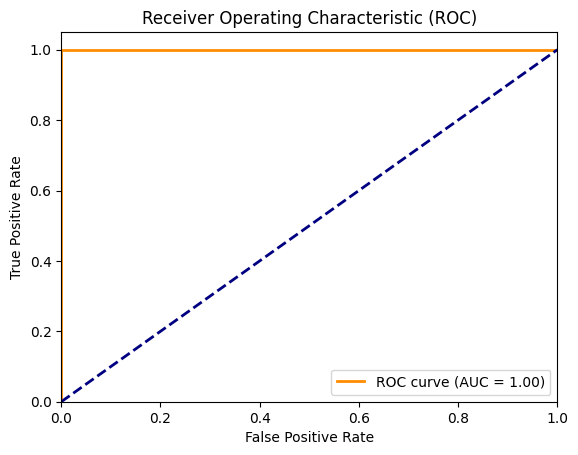

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25

Coefficients and p-values:
                            Logit Regression Results                           
Dep. Variable:             is_bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       55
Method:                           MLE   Df Model:                           13
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        01:12:43   Log-Likelihood:            -5.9165e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 7.589e-07
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

In [24]:
train_features, y_train = transform_time_series_binary(train_data, best_l)
test_features, y_test = transform_time_series_binary(test_data, best_l)

X_train = train_features[l_best_predcitors[best_l]]
X_test = test_features[l_best_predcitors[best_l]]

# Logistic regression model without penalty
LR_model = LogisticRegression(solver='liblinear', C=sys.maxsize)
LR_model.fit(X_train, y_train)

y_train_pred = LR_model.predict(X_train)
y_train_prob = LR_model.predict_proba(X_train)[:, 1]  # Probabilities of the positive class

report_pred_results(y_train_pred, y_train, y_train_prob)
report_LR_coefficients(X_train, y_train)

#### v. Test Classifier

In [25]:
y_test_pred = LR_model.predict(X_test)
df_accuracy_compare = pd.DataFrame([{'CV': round(max(df_l_accuracy.mean(axis=0)), 4),\
                                     "Test": round(accuracy_score(y_test, y_test_pred), 4)}])

print(df_accuracy_compare)

       CV    Test
0  0.9857  0.9474


Confusion Matrix:
 [[15  0]
 [ 1  3]]
Area Under Curve:
 1.0


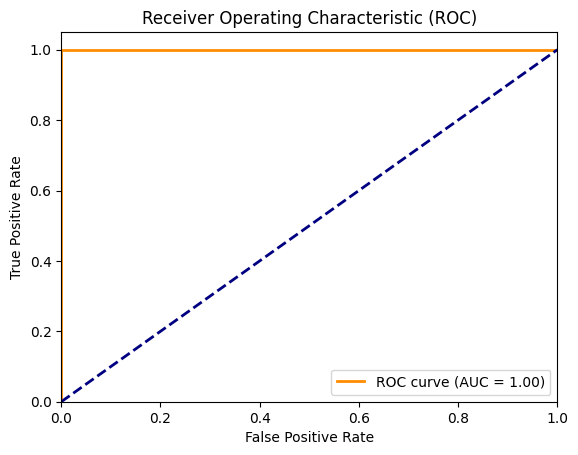

In [26]:
# Report confusion matrix, ROC curve and AUC of test data
y_test_prob = LR_model.predict_proba(X_test)[:, 1]
report_pred_results(y_test_pred, y_test, y_test_prob)

#### vi. Separation

The classes (bending and non-bending) are not well separated. 

If use K-Fold Cross Validation, some folds may not contain data points from minority class. Thus, Stratified K-fold Cross Validation has been applied.

#### vii. Imbalance

From the confusion matrix, there are 60 negative (non-bending) instances and 9 positive (bending) instances in training data set while there are 15 negative (non-bending) instances and 4 poisitive (bending) instances in test data set.

Therefore, **there are imbanlanced classes** (bending and non-bending).

##### Oversampling

Ref:

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [27]:
print("Number of positive instances before oversampling:", sum(y_train))
print("Number of negative instances before oversampling:", len(y_train) - sum(y_train))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Number of positive instances after oversampling:", sum(y_train_res))
print("Number of negative instances after oversampling:", len(y_train_res) - sum(y_train_res))

Number of positive instances before oversampling: 9
Number of negative instances before oversampling: 60
Number of positive instances after oversampling: 60
Number of negative instances after oversampling: 60


##### Report confusion matrix, ROC, and AUC

Confusion Matrix:
 [[60  0]
 [ 0 60]]
Area Under Curve:
 1.0


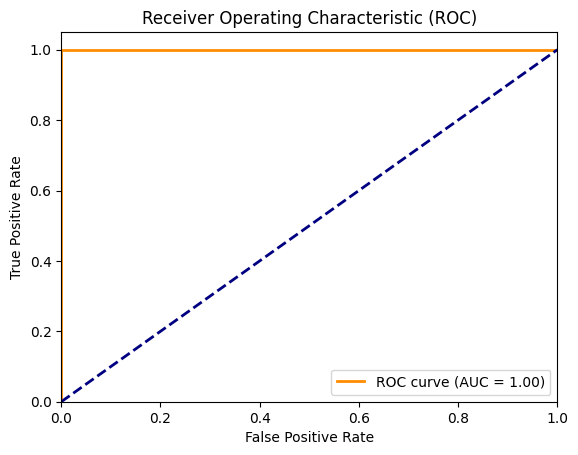

In [28]:
# Training data
LR_model.fit(X_train_res, y_train_res)

y_train_res_pred = LR_model.predict(X_train_res)
y_train_res_prob = LR_model.predict_proba(X_train_res)[:, 1]

report_pred_results(y_train_res_pred, y_train_res, y_train_res_prob)

Confusion Matrix:
 [[15  0]
 [ 0  4]]
Area Under Curve:
 1.0


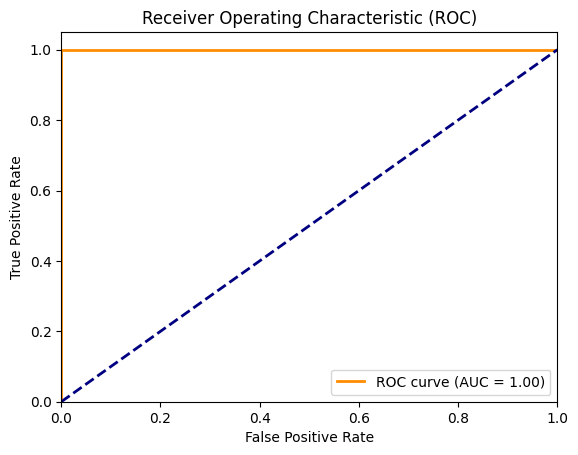

In [29]:
# Test data
y_test_res_pred = LR_model.predict(X_test)
y_test_res_prob = LR_model.predict_proba(X_test)[:, 1]

report_pred_results(y_test_res_pred, y_test, y_test_res_prob)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

##### L1 Regularization

Ref:

1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV

2. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

In [30]:
l_list = [i for i in range(1, 21)]
V_N_FOLD = 5
l_l1_accuracy_dict = {}
l_l1_lambada = {}

for l in tqdm(l_list):
    X, y = transform_time_series_binary(train_data, l)
    
    scaler = MinMaxScaler()
    norm_X = scaler.fit_transform(X)
    
    # Set logistic regression model with L1 penalty
    L1_LR_model = LogisticRegressionCV(cv=V_N_FOLD, solver='liblinear', penalty='l1')
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=V_N_FOLD, shuffle=True, random_state=42)
    accuracy_list = []
    l1_lambda_list = []
    
    for train_index, val_index in cv.split(norm_X, y):
        X_train, X_val = norm_X[train_index], norm_X[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]
        
        # Fit logisitic model with best predictors
        L1_LR_model.fit(X_train, y_train)
        penalty = L1_LR_model.C_[0]
        l1_lambda_list.append(round(float(1 / penalty), 4))
        
        y_val_pred = L1_LR_model.predict(X_val)
        
        accuracy_list.append(accuracy_score(y_val, y_val_pred))
    
    l_l1_accuracy_dict[l] = accuracy_list
    
    # Choose l1 lambda from fold that has best f1 score
    k_fold_idx = np.argmax(accuracy_list)
    l_l1_lambada[l] = l1_lambda_list[k_fold_idx]

df_l_l1_accuracy = pd.DataFrame(l_l1_accuracy_dict)
print(df_l_l1_accuracy)

100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]

         1         2         3         4         5         6         7   \
0  0.857143  0.928571  0.928571  0.928571  0.857143  0.857143  0.857143   
1  0.928571  0.928571  1.000000  0.857143  0.857143  0.857143  0.857143   
2  1.000000  0.928571  0.928571  0.928571  0.928571  0.928571  0.928571   
3  0.928571  1.000000  0.857143  0.857143  0.857143  0.857143  0.928571   
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

         8         9         10        11        12        13        14  \
0  0.857143  0.928571  0.857143  0.857143  0.857143  0.857143  0.857143   
1  0.857143  0.857143  0.857143  0.857143  0.928571  0.857143  0.857143   
2  0.928571  0.928571  0.928571  1.000000  1.000000  0.928571  0.928571   
3  0.857143  0.857143  0.785714  0.928571  0.857143  0.928571  0.928571   
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

         15        16        17        18        19        20  
0  0.857143  0.928571  0.857143  0

In [31]:
print(df_l_l1_accuracy.mean(axis=0))

1     0.942857
2     0.957143
3     0.942857
4     0.914286
5     0.900000
6     0.900000
7     0.914286
8     0.900000
9     0.914286
10    0.885714
11    0.928571
12    0.928571
13    0.914286
14    0.914286
15    0.885714
16    0.900000
17    0.885714
18    0.942857
19    0.942857
20    0.914286
dtype: float64


In [32]:
best_l1_l = np.argmax(df_l_l1_accuracy.mean(axis=0)) + 1
print("Best l for Logistic Regression with L1 regularization:", best_l1_l)
print(f"Best lambda for l = {best_l1_l}:", l_l1_lambada[best_l1_l])
print(f"Average accuracy of cross validation for l={best_l1_l}:", round(max(df_l_l1_accuracy.mean(axis=0)), 4))

Best l for Logistic Regression with L1 regularization: 2
Best lambda for l = 2: 0.3594
Average accuracy of cross validation for l=2: 0.9571


##### Report confusion matrix, ROC, and AUC

Accuracy of Logistic Regression with L1 penalty for training data:
 1.0
Confusion Matrix:
 [[60  0]
 [ 0  9]]
Area Under Curve:
 1.0


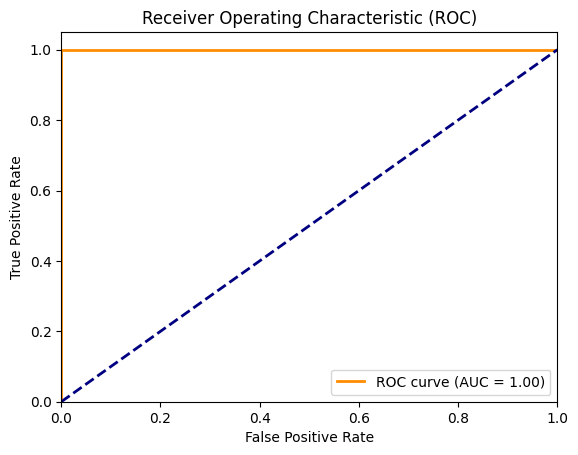

In [33]:
train_features, y_train = transform_time_series_binary(train_data, best_l1_l)
test_features, y_test = transform_time_series_binary(test_data, best_l1_l)

scale = MinMaxScaler()
X_train = scale.fit_transform(train_features)
X_test = scale.fit_transform(test_features)

# Logistic regression model with L1 penalty
L1_LR_model = LogisticRegression(solver='liblinear', penalty='l1',\
                              C=round(float(1 / l_l1_lambada[best_l1_l]), 4))
L1_LR_model.fit(X_train, y_train)

# Report confusion matrix, ROC curve and AUC of training data
y_train_pred = L1_LR_model.predict(X_train)
y_train_prob = L1_LR_model.predict_proba(X_train)[:, 1]  # Probabilities of the positive class

print("Accuracy of Logistic Regression with L1 penalty for training data:\n",\
      round(accuracy_score(y_train, y_train_pred), 4))
report_pred_results(y_train_pred, y_train, y_train_prob)

Accuracy of Logistic Regression with L1 penalty for test data:
 0.9474
Confusion Matrix:
 [[15  0]
 [ 1  3]]
Area Under Curve:
 0.9666666666666667


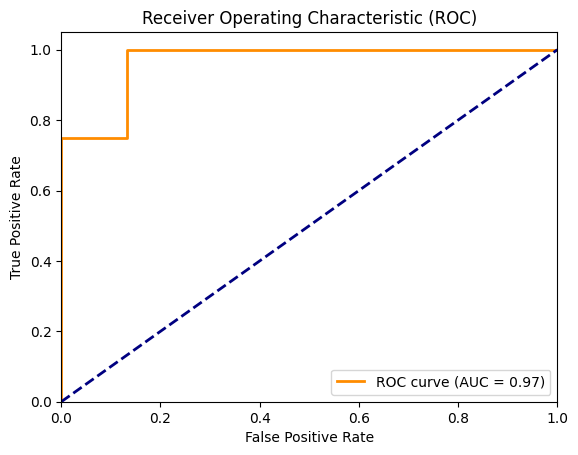

In [34]:
# Report confusion matrix, ROC curve and AUC of test data
y_test_pred = L1_LR_model.predict(X_test)
print("Accuracy of Logistic Regression with L1 penalty for test data:\n",\
      round(accuracy_score(y_test, y_test_pred), 4))

y_test_prob = L1_LR_model.predict_proba(X_test)[:, 1]
report_pred_results(y_test_pred, y_test, y_test_prob)

#### ii. Comparison

Comparision between L1-penalized and variable selection using p-values:

|                | p-value | L1 penalty |
|----------------|---------|------------|
| Train Accuracy | 1.0     | 1.0        |
| Train AUC      | 1.0     | 1.0        |
| Test Accuracy  | 0.9474  | 0.9474     |
| Test AUC       | 1.0     | 0.9667     |

L-1 penalized Logistic Regression didn't perform better than variable selection based on p-values.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [35]:
def select_data_multi(time_domain_features: pd.DataFrame,\
                       desired_series: list,\
                       desired_features: list) -> pd.DataFrame:
    """
    Select time domain features from certain time series
    Args:
        time_domain_features: origin data of all time domain features from all time series
        desired_series: list of desired time series
        desired_features: list of desired features
    """
    desired_column_names = []
    for f in desired_features:
        for s in desired_series:
            desired_column_names.append(f + '_' + s)
    
    desired_column_names.append(C_ACTIVITY)
    
    return time_domain_features[desired_column_names]

def transform_time_series_multi(data: dict, l: int):
    """
    1. Add 'activity' class as response variable
    2. Split origin time series into l eqaul length time series
    3. Get desired features from splitted time series
    Args:
        data: keys are instance names, values are dataframes of origin time series
        l: number of splits
    Return: df_selected_features
    """
    df_splitted_features = pd.DataFrame()
    
    for key, value in data.items():
        df_instance_splitted_features = split_time_series(value, l)
        df_instance_splitted_features[C_ACTIVITY] = key.split('_')[0]

        df_splitted_features = pd.concat([df_splitted_features, df_instance_splitted_features], axis=0)
    
    df_splitted_features = df_splitted_features.reset_index(drop=True)
    
    # Select min, mean, max from all split time series
    df_selected_features = select_data_multi(df_splitted_features,\
                                         gen_splitted_series_names(V_COLUMN_NAMES, l),\
                                         V_DESIRED_FEATURES)
    
    X = df_selected_features.drop(columns=[C_ACTIVITY])
    y = df_selected_features[C_ACTIVITY]
    
    return X, y

##### Logistic Regression with L1 Reglarization

In [36]:
l_list = [i for i in range(1, 21)]
V_N_FOLD = 5
l_l1_multi_accuracy_dict = {}


for l in tqdm(l_list):
    X, y = transform_time_series_multi(train_data, l)
    
    scaler = MinMaxScaler()
    norm_X = scaler.fit_transform(X)
    
    # Set logistic regression model with L1 penalty
    L1_MULTI_LR_model = LogisticRegressionCV(cv=V_N_FOLD, solver='liblinear',\
                                       penalty='l1', max_iter=1000, multi_class='auto')
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=V_N_FOLD, shuffle=True, random_state=42)
    accuracy_list = []
    l1_penalty_list = []
    
    for train_index, val_index in cv.split(norm_X, y):
        X_train, X_val = norm_X[train_index], norm_X[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]
        
        # Fit logisitic model with best predictors
        L1_MULTI_LR_model.fit(X_train, y_train)
        
        y_val_pred = L1_MULTI_LR_model.predict(X_val)
        
        accuracy_list.append(accuracy_score(y_val, y_val_pred))
    
    l_l1_multi_accuracy_dict[l] = accuracy_list
    
df_l_l1_multi_accuracy = pd.DataFrame(l_l1_multi_accuracy_dict)
print(df_l_l1_multi_accuracy)

100%|███████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it]

         1         2         3         4         5         6         7   \
0  0.857143  0.642857  0.357143  0.500000  0.642857  0.500000  0.500000   
1  0.714286  0.642857  0.714286  0.857143  0.785714  0.642857  0.714286   
2  0.714286  0.785714  0.785714  0.500000  0.714286  0.500000  0.500000   
3  0.785714  0.857143  0.571429  0.857143  0.642857  0.571429  0.357143   
4  0.692308  0.538462  0.461538  0.538462  0.538462  0.538462  0.538462   

         8         9         10        11        12        13        14  \
0  0.571429  0.571429  0.571429  0.642857  0.571429  0.714286  0.642857   
1  0.500000  0.785714  0.642857  0.428571  0.571429  0.714286  0.500000   
2  0.428571  0.500000  0.785714  0.500000  0.571429  0.714286  0.500000   
3  0.714286  0.500000  0.642857  0.571429  0.571429  0.571429  0.642857   
4  0.615385  0.538462  0.384615  0.461538  0.461538  0.615385  0.538462   

         15        16        17        18        19        20  
0  0.642857  0.500000  0.500000  0

In [37]:
print("Average accuracy score of CV for each l:\n", df_l_l1_multi_accuracy.mean(axis=0))

Average accuracy score of CV for each l:
 1     0.752747
2     0.693407
3     0.578022
4     0.650549
5     0.664835
6     0.550549
7     0.521978
8     0.565934
9     0.579121
10    0.605495
11    0.520879
12    0.549451
13    0.665934
14    0.564835
15    0.505495
16    0.491209
17    0.594505
18    0.506593
19    0.608791
20    0.505495
dtype: float64


In [38]:
best_l1_multi_l = np.argmax(df_l_l1_multi_accuracy.mean(axis=0)) + 1
print("Best l for Logistic Regression with L1 regularization (multi-class):", best_l1_multi_l)
print(f"Average accuracy of cross validation for l={best_l1_multi_l}:", round(max(df_l_l1_multi_accuracy.mean(axis=0)), 4))

Best l for Logistic Regression with L1 regularization (multi-class): 1
Average accuracy of cross validation for l=1: 0.7527


##### Report confusion matrix, ROC and AUC

In [39]:
def report_multi_pred_results(y_pred, y_actual, y_prob, multi_classes):
    """
    Report prediction results of multi-classes classification
    Args:
        y_pred: predicted y
        y_actual: actual value of y
        y_prob: predicted probabilities of multiple classes
        multi_classes: list of multiple classes
    """
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Binarize the labels for multi-class
    y_actual_bin = label_binarize(y_actual, classes=multi_classes)
    n_classes = y_actual_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_actual_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(multi_classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

Accuracy of Logistic Regression with L1 penalty for training data:
 0.8696
Confusion Matrix:
 [[ 3  0  0  0  2  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 11  0  1  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  6  6  0]
 [ 0  0  0  0  0  0 12]]


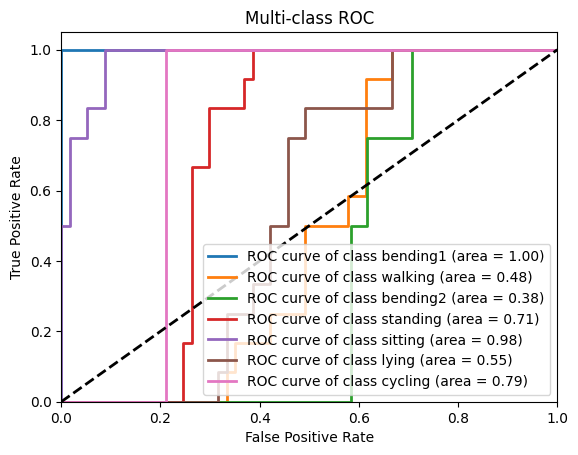

In [40]:
X_train, y_train = transform_time_series_multi(train_data, best_l1_multi_l)
X_test, y_test = transform_time_series_multi(test_data, best_l1_multi_l)

V_MULTI_CLASSES = list(y_train.drop_duplicates())

scaler = MinMaxScaler()
norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.fit_transform(X_test)


# Set logistic regression model with L1 penalty (multi-classes)
L1_MULTI_LR_model = LogisticRegressionCV(solver='liblinear', penalty='l1')
L1_MULTI_LR_model.fit(norm_X_train, y_train)
y_train_pred = L1_MULTI_LR_model.predict(norm_X_train)
y_train_prob = L1_MULTI_LR_model.predict_proba(norm_X_train)

print("Accuracy of Logistic Regression with L1 penalty for training data:\n",\
      round(accuracy_score(y_train, y_train_pred), 4))
report_multi_pred_results(y_train_pred, y_train, y_train_prob, V_MULTI_CLASSES)

Accuracy of Logistic Regression with L1 penalty for test data:
 0.8421
Confusion Matrix:
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 1 2 0 0]
 [0 0 0 0 0 0 3]]


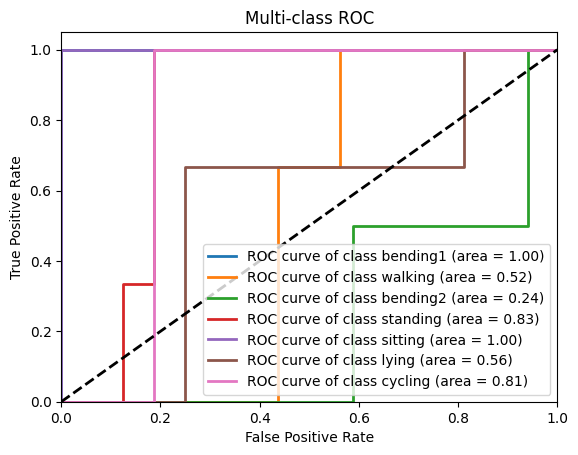

In [41]:
# Test data
y_test_pred = L1_MULTI_LR_model.predict(norm_X_test)
y_test_prob = L1_MULTI_LR_model.predict_proba(norm_X_test)

print("Accuracy of Logistic Regression with L1 penalty for test data:\n",\
      round(accuracy_score(y_test, y_test_pred), 4))
report_multi_pred_results(y_test_pred, y_test, y_test_prob, V_MULTI_CLASSES)

As above, logistic regression with L1 regularization performs well in classifying class bending1, standing, sitting, and cycling while performs poor in classifying walking, bending2, and lying.

#### ii. Naive Bayes

##### Gaussian

In [42]:
l_list = [i for i in range(1, 21)]
V_N_FOLD = 5
l_gaussian_accuracy_dict = {}


for l in tqdm(l_list):
    X, y = transform_time_series_multi(train_data, l)
    
    # Set Gaussian Naive Bayers classifier
    Gaussian_model = GaussianNB()
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=V_N_FOLD, shuffle=True, random_state=42)
    accuracy_list = []
    l1_penalty_list = []
    
    for train_index, val_index in cv.split(X, y):
        X_train, X_val = X.loc[train_index], X.loc[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]
        
        # Fit Gaussian Naive Bayes model with best predictors
        Gaussian_model.fit(X_train, y_train)
        
        y_val_pred = Gaussian_model.predict(X_val)
        
        accuracy_list.append(accuracy_score(y_val, y_val_pred))
    
    l_gaussian_accuracy_dict[l] = accuracy_list
    
    
df_l_gaussian_accuracy = pd.DataFrame(l_gaussian_accuracy_dict)
print(df_l_gaussian_accuracy)

100%|███████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

         1         2         3         4         5         6         7   \
0  0.785714  0.785714  0.785714  0.785714  0.785714  0.785714  0.857143   
1  0.785714  1.000000  0.857143  0.857143  0.857143  0.785714  0.785714   
2  0.714286  0.785714  0.928571  0.785714  0.857143  0.714286  0.785714   
3  0.857143  0.785714  0.714286  0.857143  0.785714  0.785714  0.785714   
4  0.846154  0.846154  0.538462  0.615385  0.538462  0.538462  0.461538   

         8         9         10        11        12        13        14  \
0  0.785714  0.714286  0.714286  0.785714  0.642857  0.642857  0.642857   
1  0.857143  0.785714  0.928571  0.785714  0.642857  0.857143  0.642857   
2  0.714286  0.785714  0.785714  0.714286  0.642857  0.642857  0.571429   
3  0.785714  0.714286  0.714286  0.642857  0.571429  0.642857  0.571429   
4  0.538462  0.461538  0.384615  0.461538  0.538462  0.615385  0.461538   

         15        16        17        18        19        20  
0  0.571429  0.642857  0.571429  0

In [43]:
print("Average accuracy score of CV for each l:\n", df_l_gaussian_accuracy.mean(axis=0))

Average accuracy score of CV for each l:
 1     0.797802
2     0.840659
3     0.764835
4     0.780220
5     0.764835
6     0.721978
7     0.735165
8     0.736264
9     0.692308
10    0.705495
11    0.678022
12    0.607692
13    0.680220
14    0.578022
15    0.580220
16    0.564835
17    0.607692
18    0.534066
19    0.580220
20    0.593407
dtype: float64


In [44]:
best_gaussian_l = np.argmax(df_l_gaussian_accuracy.mean(axis=0)) + 1
print("Best l for Gaussian Naive Bayes classifier (multi-class):", best_gaussian_l)
print(f"Average accuracy of cross validation for l={best_gaussian_l}:", round(max(df_l_gaussian_accuracy.mean(axis=0)), 4))

Best l for Gaussian Naive Bayes classifier (multi-class): 2
Average accuracy of cross validation for l=2: 0.8407


Accuracy of Gaussian Naive Bayes classifier for training data:
 1.0
Confusion Matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]


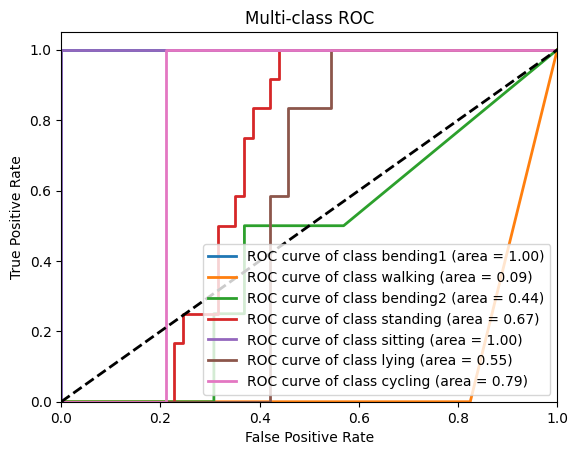

In [45]:
X_train, y_train = transform_time_series_multi(train_data, best_gaussian_l)
X_test, y_test = transform_time_series_multi(test_data, best_gaussian_l)

V_MULTI_CLASSES = list(y_train.drop_duplicates())

# Set Gaussian Naive Bayers classifier
Gaussian_model = GaussianNB()
Gaussian_model.fit(X_train, y_train)
y_train_pred = Gaussian_model.predict(X_train)
y_train_prob = Gaussian_model.predict_proba(X_train)

print("Accuracy of Gaussian Naive Bayes classifier for training data:\n",\
      round(accuracy_score(y_train, y_train_pred), 4))
report_multi_pred_results(y_train_pred, y_train, y_train_prob, V_MULTI_CLASSES)

Accuracy of Gaussian Naive Bayes classifier for test data:
 0.9474
Confusion Matrix:
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


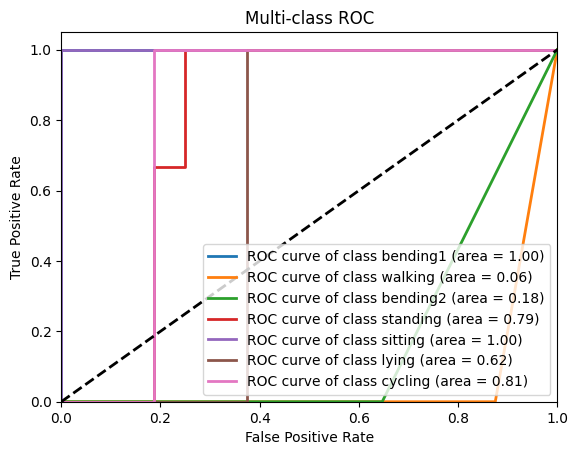

In [46]:
# Test data
y_test_pred = Gaussian_model.predict(X_test)
y_test_prob = Gaussian_model.predict_proba(X_test)

print("Accuracy of Gaussian Naive Bayes classifier for test data:\n",\
      round(accuracy_score(y_test, y_test_pred), 4))
report_multi_pred_results(y_test_pred, y_test, y_test_prob, V_MULTI_CLASSES)

##### Multinomial

In [47]:
l_list = [i for i in range(1, 21)]
V_N_FOLD = 5
l_mnnb_accuracy_dict = {}


for l in tqdm(l_list):
    X, y = transform_time_series_multi(train_data, l)
    
    # Set Multinomial Naive Bayers classifier
    MNNB_model = MultinomialNB()
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=V_N_FOLD, shuffle=True, random_state=42)
    accuracy_list = []
    l1_penalty_list = []
    
    for train_index, val_index in cv.split(X, y):
        X_train, X_val = X.loc[train_index], X.loc[val_index]
        y_train, y_val = y.loc[train_index], y.loc[val_index]
        
        # Fit Multinomial Naive Bayes model with best predictors
        MNNB_model.fit(X_train, y_train)
        
        y_val_pred = MNNB_model.predict(X_val)
        
        accuracy_list.append(accuracy_score(y_val, y_val_pred))
    
    l_mnnb_accuracy_dict[l] = accuracy_list
    
    
df_l_mnnb_accuracy = pd.DataFrame(l_mnnb_accuracy_dict)
print(df_l_mnnb_accuracy)

100%|███████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]

         1         2         3         4         5         6         7   \
0  0.714286  0.785714  0.785714  0.785714  0.785714  0.785714  0.785714   
1  0.857143  0.785714  0.857143  0.857143  0.785714  0.857143  0.857143   
2  0.857143  0.857143  0.928571  0.785714  0.857143  0.785714  0.857143   
3  0.714286  0.714286  0.714286  0.714286  0.785714  0.857143  0.785714   
4  0.769231  0.538462  0.538462  0.538462  0.615385  0.769231  0.692308   

         8         9         10        11        12        13        14  \
0  0.785714  0.785714  0.785714  0.785714  0.714286  0.785714  0.785714   
1  0.857143  0.785714  0.857143  0.785714  0.785714  0.928571  0.785714   
2  0.785714  0.785714  0.714286  0.785714  0.785714  0.785714  0.785714   
3  0.857143  0.857143  0.857143  0.857143  0.785714  0.857143  0.785714   
4  0.692308  0.615385  0.692308  0.615385  0.615385  0.692308  0.615385   

         15        16        17        18        19        20  
0  0.714286  0.714286  0.714286  0

In [48]:
print("Average accuracy score of CV for each l:\n", df_l_mnnb_accuracy.mean(axis=0))

Average accuracy score of CV for each l:
 1     0.782418
2     0.736264
3     0.764835
4     0.736264
5     0.765934
6     0.810989
7     0.795604
8     0.795604
9     0.765934
10    0.781319
11    0.765934
12    0.737363
13    0.809890
14    0.751648
15    0.737363
16    0.721978
17    0.751648
18    0.738462
19    0.750549
20    0.737363
dtype: float64


In [49]:
best_mnnb_l = np.argmax(df_l_mnnb_accuracy.mean(axis=0)) + 1
print("Best l for Multinomial Naive Bayes classifier (multi-class):", best_mnnb_l)
print(f"Average accuracy of cross validation for l={best_mnnb_l}:", round(max(df_l_mnnb_accuracy.mean(axis=0)), 4))

Best l for Multinomial Naive Bayes classifier (multi-class): 6
Average accuracy of cross validation for l=6: 0.811


Accuracy of Multinomial Naive Bayes classifier for training data:
 0.913
Confusion Matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 10  0  2  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]


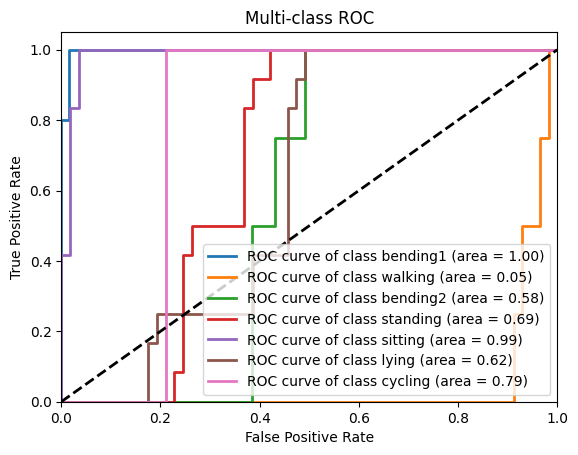

In [50]:
X_train, y_train = transform_time_series_multi(train_data, best_mnnb_l)
X_test, y_test = transform_time_series_multi(test_data, best_mnnb_l)

V_MULTI_CLASSES = list(y_train.drop_duplicates())

# Set Gaussian Naive Bayers classifier
MNNB_model = MultinomialNB()
MNNB_model.fit(X_train, y_train)
y_train_pred = MNNB_model.predict(X_train)
y_train_prob = MNNB_model.predict_proba(X_train)

print("Accuracy of Multinomial Naive Bayes classifier for training data:\n",\
      round(accuracy_score(y_train, y_train_pred), 4))
report_multi_pred_results(y_train_pred, y_train, y_train_prob, V_MULTI_CLASSES)

Accuracy of Multinomial Naive Bayes classifier for test data:
 0.7368
Confusion Matrix:
 [[2 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]


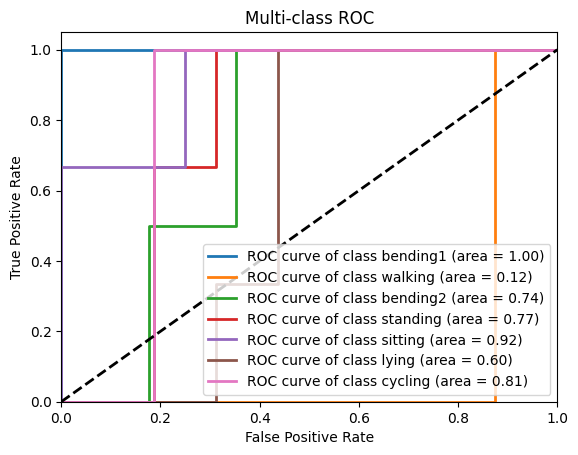

In [51]:
# Test data
y_test_pred = MNNB_model.predict(X_test)
y_test_prob = MNNB_model.predict_proba(X_test)

print("Accuracy of Multinomial Naive Bayes classifier for test data:\n",\
      round(accuracy_score(y_test, y_test_pred), 4))
report_multi_pred_results(y_test_pred, y_test, y_test_prob, V_MULTI_CLASSES)

#### ii. Comparison

|                | L1 penalty | Gaussian | Multinomial |
|----------------|------------|----------|-------------|
| Train Accuracy | 0.8696     | 1.0      | 0.913       |
| Test Accuracy  | 0.8421     | 0.9474   | 0.7368      |

In this case, the **best** classifier is **Gaussian Naive Bayes classifier** with highest training accuracy and test accurcy.

## 3. ISLR 4.8.3

With p=1, $X~N(\mu_k, \sigma_k^2)$

$f_k(x)=\frac{1}{\sqrt{2\pi}\sigma_k}e^-\frac{1}{2}(\frac{x-\mu_k}{\sigma_k})^2$

$p_k(x)=\frac{\pi_k \frac{1}{\sqrt{2\pi}\sigma_k}e^-\frac{1}{2}(\frac{x-\mu_k}{\sigma_k})^2}{\sum_{l=1}^{K} \frac{1}{\sqrt{2\pi}\sigma_l}e^-\frac{1}{2}(\frac{x-\mu_l}{\sigma_l})^2}$

, where $\sigma_k$ is different in different classes

$k^* = argmax \text{ } p_k = argmax \text{ } \pi_k f_k(x) = argmax \text{ } log(\pi_k f_k(x))$

$= argmax \text{ } log\pi_k + log\frac{1}{\sqrt{2\pi}\sigma_k} - \frac{1}{2}(\frac{x-\mu_k}{\sigma_k})^2$

$= argmax \text{ } log\pi_k + log\frac{1}{\sqrt{2\pi}\sigma_k} - \frac{1}{2}(\frac{x^2- 2\mu_k x + \mu_k^2}{\sigma_k^2})$

$= argmax \text{ } log\pi_k + log\frac{1}{\sqrt{2\pi}\sigma_k} - \frac{x^2}{2\sigma_k^2} + \frac{\mu_k x}{2\sigma_k^2} - \frac{\mu_k^2}{2\sigma_k^2}$

Discriminant function $\delta_k(x)=log\pi_k + log\frac{1}{\sqrt{2\pi}\sigma_k} - \frac{x^2}{2\sigma_k^2} + \frac{\mu_k x}{2\sigma_k^2} - \frac{\mu_k^2}{2\sigma_k^2}$, which is a **quadratic** function of x.

The decision boundary between class i and class j is **$\delta_i(x)=\delta_j(x)$.** In this case, it's a **quandratic function of x.** Thus, in this case, Bayes classifier is **not linear**, it is in fact **quandratic**.

## 4. ISLR 4.8.7

Known $\hat{\mu_Y}=10$, $\hat{\mu_N}=0$, $\hat{\sigma^2}=36, \pi_Y=0.8$

$f_Y(x)=\frac{1}{\sqrt{2\pi}\sigma}e^-\frac{1}{2}(\frac{x-\mu_Y}{\sigma})^2 = \frac{1}{\sqrt{2\pi} \times 6}e^-\frac{1}{2}(\frac{x-10}{6})^2 = \frac{1}{\sqrt{2\pi} \times 6}e^-\frac{1}{2}(\frac{4-10}{6})^2 \approx 0.0403$

$f_N(x)=\frac{1}{\sqrt{2\pi}\sigma}e^-\frac{1}{2}(\frac{x-\mu_N}{\sigma})^2 = \frac{1}{\sqrt{2\pi} \times 6}e^-\frac{1}{2}(\frac{x-0}{6})^2 = \frac{1}{\sqrt{2\pi} \times 6}e^-\frac{1}{2}(\frac{4-0}{6})^2 \approx 0.0212$

$\pi_Yf_Y(x)=0.8 \times 0.0403 \approx 0.0322$

$\pi_Nf_N(x)=(1-0.2) \times 0.0212 \approx 0.0042$

$p_Y(x)=\frac{\pi_Yf_Y(x)}{\pi_Yf_Y(x) + \pi_Nf_N(x)} = \frac{0.0322}{0.0322+0.0042} \approx 0.8846$ 

The probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year is **88.46%**.

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9